# Monotonic splines

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

In [2]:
cells = la.Dim(pd.Series(range(600), name="cell").astype(str))
genes = la.Dim(pd.Series(range(5), name="gene").astype(str))
knots = la.Dim(range(5), "knot")

In [3]:
x_value = (
    pd.Series(
        np.random.choice((0, 1, 2, 3, 4), len(cells)), index=cells.index, name="knot"
    )
    .astype(float)
    .astype("category")
)
x = la.variables.discrete.DiscreteFixed(x_value)
a_gs = la.Fixed(pd.Series([0.5, 0, 1, 2, 1.5], index=knots.index).astype(float))
y = la.links.vector.Matmul(x=x, a=a_gs)
obs = la.distributions.Normal(y)

In [4]:
obs_value = obs.prior_pd()

In [5]:
a = la.Parameter(0.0, definition=[knots])
y = la.links.vector.Matmul(x=x, a=a)

In [6]:
dist = la.distributions.Normal(y)
obs = la.Observation(obs_value, dist)

  0%|                                                                                                         …

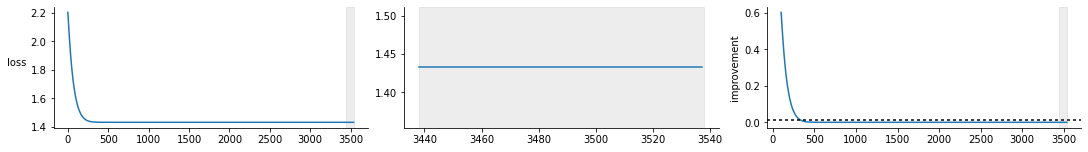

In [7]:
inference = la.infer.svi.SVI(obs, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)
trace.plot()

<AxesSubplot:xlabel='knot'>

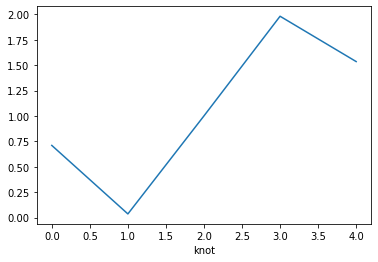

In [8]:
a.prior_pd().plot()

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

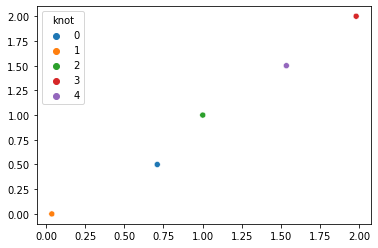

In [9]:
sns.scatterplot(
    a.prior_pd(), a_gs.prior_pd(), hue=a.prior_pd().index.astype("category")
)

In [10]:
a_unconstrained = la.Parameter(0.0, definition=[knots])
a = la.links.vector.Monotonic(a_unconstrained)
y = la.links.vector.Matmul(x=x, a=a)

In [11]:
dist = la.distributions.Normal(y)
obs = la.Observation(obs_value, dist)

  0%|                                                                                                         …

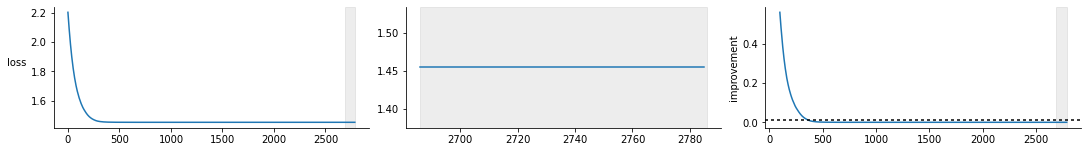

In [12]:
inference = la.infer.svi.SVI(obs, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)
trace.plot()

In [13]:
torch.minimum(torch.tensor(0.1), torch.tensor([1.0, 2.0, 3.0]))

tensor([0.1000, 0.1000, 0.1000])

<AxesSubplot:xlabel='knot'>

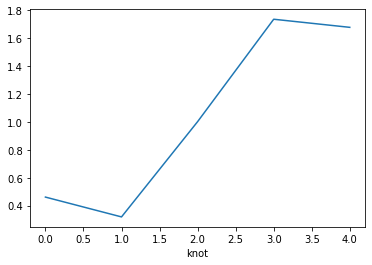

In [14]:
a.prior_pd().plot()

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

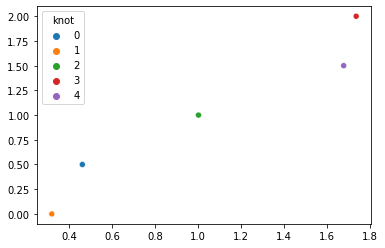

In [15]:
sns.scatterplot(
    a.prior_pd(), a_gs.prior_pd(), hue=a.prior_pd().index.astype("category")
)

## Random walks

In [16]:
sign = la.distributions.Bernouilli(0.5, transforms=[la.transforms.Sign()])
dist = la.distributions.MonotonicRandomWalk(
    11, la.distributions.HalfNormal(), sign=sign
)
knots = dist[0]

In [17]:
sign.reset()
sign.run()
sign.likelihood

tensor(-0.6931)

In [18]:
dist2 = la.distributions.RandomWalk(len(knots), la.distributions.Normal())

In [19]:
dist.reset()
dist.run()
dist.value
print("lik     : " + str(dist.likelihood))
print("log_prob: " + str(dist._log_prob(dist.value)))
# assert torch.isclose(dist.log_prob(dist.value), dist.likelihood, atol = 1e-3)
""

lik     : tensor([-5.9591])
log_prob: tensor([-5.9591])


''

In [20]:
dist.value

tensor([0.0000, 0.2818, 1.3454, 1.6447, 1.9178, 2.8336, 3.8799, 5.5186, 5.5484,
        5.5565, 5.7028])

In [21]:
import math

dist.reset()
dist.run()
dist2.run()
print(dist2.log_prob(dist.value))
print(dist.log_prob(dist.value))
print(dist.likelihood)

fold_difference = (dist.likelihood - dist2.log_prob(dist.value)) / math.log(2.0)
print(fold_difference)
assert torch.isclose(
    fold_difference, torch.tensor(len(knots)).float() - 1, atol=1e-1, rtol=1e-1
), "A monotonic spline with HalfNormal should have double the likelihood per step as a regular spline with Normal"
""

tensor([-14.1724])
tensor([-7.9341])
tensor([-7.9341])
tensor([9.0000])


''

In [22]:
steps = torch.cat([torch.tensor([0.0]), torch.ones(len(knots) - 1)])

value = torch.cumsum(steps, 0)
lik = dist.log_prob(value)
print(lik)

#
steps = -torch.cat([torch.tensor([0.0]), torch.ones(len(knots) - 1)])

value = torch.cumsum(steps, 0)
lik = dist.log_prob(value)
print(lik)

tensor([-7.9511])
tensor([-7.9511])


In [23]:
#
steps = torch.cat([torch.tensor([0.0]), torch.ones(len(knots) - 1)])
steps[: int(len(steps) / 2) + 1] *= -1
print(steps)

value = torch.cumsum(steps, 0)
lik = dist.log_prob(value)
print(lik)

tensor([-0., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.])
tensor([-14.8825])


----

In [24]:
latent = la.Latent(dist)
# latent.q = la.distributions.Delta(latent.q.loc, transforms = latent.q.transforms, dependent_dims = latent.q.dependent_dims)

# latent.q.scale.loader.value.data[1:] = torch.log(torch.tensor(0.1))

In [25]:
latent.reset()
latent.run()
print(latent.likelihood)
print(latent.posterior)

tensor([-5.8799], grad_fn=<AddBackward0>)
tensor([-3.2400], grad_fn=<SumBackward1>)


In [26]:
latent.q.prior()

tensor([ 0.2759, -0.0829, -0.3731, -0.1667, -0.1998,  0.3317, -0.0256, -0.5890,
         0.4760,  0.4351,  0.3356])

In [27]:
latent.q.loc = la.links.vector.Monotonic(latent.q.loc)

In [28]:
latent.plot()

In [29]:
# latent.q.loc.loader.value.data[0] = 3.

liks = []
for i in range(500):
    latent.reset()
    latent.run()
    liks.append(latent.likelihood)
torch.cat(liks).mean()

tensor(-7.8606, grad_fn=<MeanBackward0>)

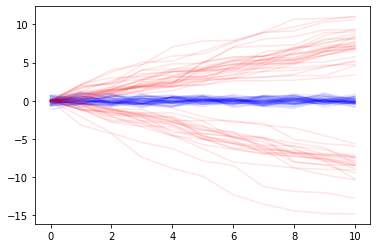

In [30]:
for i in range(50):
    latent.reset()
    latent.run()

    value = latent.p.value.cpu().numpy()
    sns.lineplot(x=np.arange(value.shape[0]), y=value, alpha=0.1, color="red")

    value = latent.q.value.detach().cpu().numpy()
    sns.lineplot(x=np.arange(value.shape[0]), y=value, alpha=0.1, color="blue")

  0%|                                                                                                         …

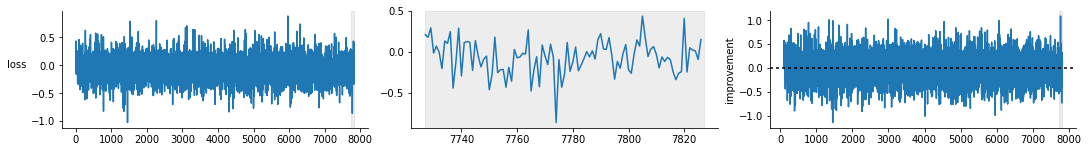

In [31]:
inference = la.infer.svi.SVI(
    latent, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)
trace.plot()

<AxesSubplot:xlabel='knot'>

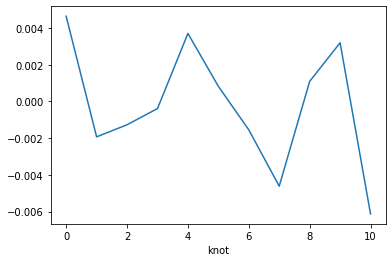

In [32]:
latent.q.loc.x.prior_pd().plot()

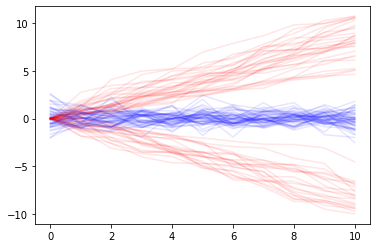

In [33]:
for i in range(50):
    latent.reset()
    latent.run()

    value = latent.p.value.cpu().numpy()
    sns.lineplot(x=np.arange(value.shape[0]), y=value, alpha=0.1, color="red")

    value = latent.q.value.detach().cpu().numpy()
    sns.lineplot(x=np.arange(value.shape[0]), y=value, alpha=0.1, color="blue")

In [34]:
knots = dist[0]

In [35]:
dist.plot()

In [36]:
knots = la.Dim(range(10), "knot")

In [37]:
dist = la.distributions.MonotonicRandomWalk(
    10, la.distributions.HalfNormal(), definition=la.Definition([genes, knots])
)

In [38]:
dist.plot()

In [39]:
dist.run()
print(dist.value)
print(dist.likelihood)

tensor([[ 0.0000, -0.6344, -2.3657, -4.5665, -5.9197, -6.3600, -8.2663, -8.3316,
         -8.6417, -9.2708],
        [ 0.0000,  1.6420,  1.9158,  1.9503,  2.4715,  4.4773,  5.3808,  6.6723,
          7.7795,  9.6520],
        [ 0.0000,  0.8013,  1.0835,  1.9517,  2.9524,  3.5887,  4.9316,  5.7812,
          7.3231,  7.5174],
        [ 0.0000,  1.6793,  2.1581,  2.6960,  2.7434,  3.3032,  3.4225,  3.8743,
          3.8941,  4.9517],
        [ 0.0000, -1.3221, -1.3850, -1.8058, -1.9479, -2.0923, -3.4748, -3.9870,
         -5.3879, -5.7700]])
tensor([[-9.9246],
        [-9.8670],
        [-6.6364],
        [-5.2211],
        [-5.8513]])


In [40]:
knots = la.Dim(range(10), "knot")

In [41]:
dist = la.distributions.MonotonicRandomWalk(
    10, la.distributions.HalfNormal(), definition=la.Definition([knots, genes])
)

In [42]:
dist.plot()

In [43]:
dist.reset()
dist.run()
print(dist.value)
print(dist.step.likelihood)
print(dist.likelihood)
print(dist.log_prob(dist.value))
print(dist.log_prob(torch.zeros(dist.value.shape)))

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5922,  0.4856, -0.2055, -1.1180, -1.2714],
        [ 1.9567,  0.4947, -0.5964, -1.4149, -3.8958],
        [ 2.4602,  1.1304, -2.4401, -2.2262, -3.9426],
        [ 2.9036,  1.2847, -2.8244, -2.7035, -4.3114],
        [ 3.8090,  1.7546, -4.0263, -3.4690, -4.5470],
        [ 4.2114,  2.4590, -4.1863, -5.1934, -4.6994],
        [ 4.7735,  2.7118, -5.0224, -6.3178, -4.7652],
        [ 5.0635,  3.5927, -5.9571, -6.5612, -6.0865],
        [ 5.4966,  4.1953, -6.0332, -7.1113, -6.5920]])
tensor([[-1.4933, -0.3437, -0.2469, -0.8507, -1.0341],
        [-0.2922, -0.2258, -0.3022, -0.2699, -3.6694],
        [-0.3526, -0.4279, -1.9254, -0.5549, -0.2269],
        [-0.3241, -0.2377, -0.2996, -0.3397, -0.2938],
        [-0.6357, -0.3362, -0.9481, -0.5187, -0.2535],
        [-0.3067, -0.4739, -0.2386, -1.7125, -0.2374],
        [-0.3837, -0.2577, -0.5753, -0.8579, -0.2280],
        [-0.2678, -0.6138, -0.6626, -0.2554, -1.0986],
        [

In [44]:
dist = la.distributions.MonotonicRandomWalk(
    10, la.distributions.HalfNormal(definition=la.Definition([genes]))
)
dist.plot()

In [45]:
dist.reset()
dist.run()
print(dist.value)
print(dist.step.likelihood)
print(dist.likelihood)
print(dist.log_prob(dist.value))
print(dist.log_prob(torch.zeros(dist.value.shape)))

tensor([[  0.0000,  -0.7618,  -1.0857,  -1.4837,  -3.2267,  -3.3761,  -3.4364,
          -3.7691,  -4.3261,  -4.5679],
        [  0.0000,   0.3124,   0.4931,   0.5083,   0.8051,   1.6468,   2.2520,
           2.6118,   2.9851,   3.3992],
        [  0.0000,  -0.1775,  -0.2230,  -1.0920,  -1.3065,  -2.4189,  -3.4425,
          -3.8051,  -3.8514,  -5.0360],
        [  0.0000,  -1.0458,  -3.3801,  -5.2144,  -5.6140,  -7.1441,  -7.6034,
          -8.5198, -10.8191, -11.2144],
        [  0.0000,   1.2619,   1.3760,   1.6268,   1.8904,   2.6866,   3.2752,
           3.3775,   3.6239,   4.7295]])
tensor([[-0.5159, -0.2783, -0.3050, -1.7447, -0.2370, -0.2276, -0.2812, -0.3809,
         -0.2550],
        [-0.2746, -0.2421, -0.2259, -0.2698, -0.5800, -0.4090, -0.2905, -0.2955,
         -0.3115],
        [-0.2416, -0.2268, -0.6034, -0.2488, -0.8445, -0.7497, -0.2915, -0.2269,
         -0.9275],
        [-0.7727, -2.9502, -1.9082, -0.3056, -1.3964, -0.3313, -0.6457, -2.8691,
         -0.3039],
    

In [46]:
genes = la.Dim(pd.Series(range(1), name="gene").astype(str))

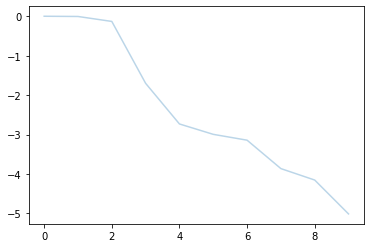

In [47]:
dist = la.distributions.MonotonicRandomWalk(
    n_knots=len(knots),
    step=la.distributions.HalfNormal(definition=la.Definition([genes])),
    sign=la.distributions.Bernouilli(0.5, transforms=[la.transforms.Sign()]),
)
dist.run()
value = dist.value.cpu().numpy()
for i in range(value.shape[0]):
    sns.lineplot(x=np.arange(value.shape[1]), y=value[i], alpha=0.3)

## Generative model

In [48]:
n_cells = 100
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name="cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 20, n_cells), index=cells.index), label="x")

In [49]:
n_knots = 10

knots = la.Dim(range(n_knots), name="knot")

steps = np.vstack(
    [
        np.zeros(n_knots),
        1 * np.ones(n_knots),
        np.random.choice([-1, 1])
        * np.abs(np.random.normal(3.0, 1.0, n_knots))
        * (np.arange(n_knots) > (n_knots / 2)),
    ]
)
n_genes = steps.shape[0]
genes = la.Dim([str(i) for i in range(n_genes)], name="gene")

a_value = steps.cumsum(1)
# a_value = a_value - a_value.mean(1, keepdims=True)
a = la.Fixed(pd.DataFrame(a_value, columns=knots.index, index=genes.index), label="a")
intercept = la.Fixed(
    pd.Series(
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(3.0, 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5),
        index=genes.index,
    ),
    label="intercept",
)
scale = la.Fixed(
    pd.Series(np.random.uniform(1.0, 1.2, n_genes), index=genes.index), label="scale"
)

In [50]:
y = la.links.scalar.Spline(x=x, a=a, b=intercept)
dist = la.distributions.Normal(loc=y, scale=scale, label="distribution")

In [51]:
model_gs = la.Root(dist=dist, label="ground truth", symbol="gs")
model_gs.plot()

In [52]:
posterior = la.posterior.Posterior(dist, retain_samples={dist.loc, dist})
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
a_value

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  1.        ,   2.        ,   3.        ,   4.        ,
          5.        ,   6.        ,   7.        ,   8.        ,
          9.        ,  10.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -4.01134243,  -6.57552617,
         -9.70277831, -12.55813475]])

<AxesSubplot:xlabel='gene', ylabel='cell'>

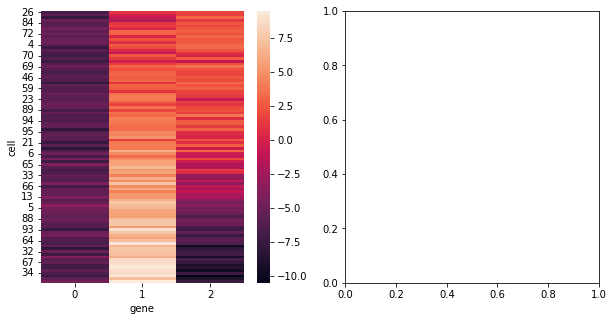

In [54]:
loc_value = posterior.samples[dist.loc].sel(sample=0).to_pandas()
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

In [55]:
a_value

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  1.        ,   2.        ,   3.        ,   4.        ,
          5.        ,   6.        ,   7.        ,   8.        ,
          9.        ,  10.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,  -4.01134243,  -6.57552617,
         -9.70277831, -12.55813475]])

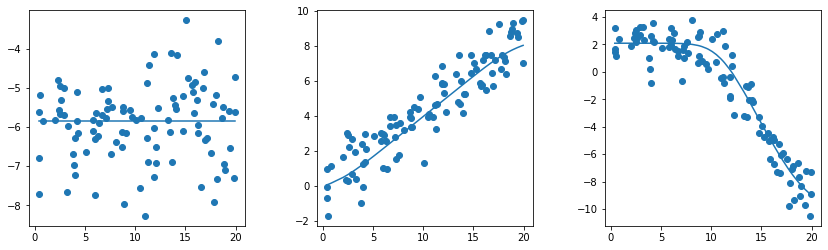

In [56]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
gene_ids = genes.coords[:10]
fig, axes = la.plotting.axes_wrap(len(gene_ids))
cell_order = model_gs.find("x").prior_pd().sort_values().index
x_value = model_gs.find("x").prior_pd()

for gene_id, ax in zip(gene_ids, axes):
    ax.scatter(x_value.loc[cell_order], observation_value.loc[cell_order, gene_id])
    ax.plot(x_value.loc[cell_order], loc_value.loc[cell_order, gene_id])
# sns.heatmap(observation_value.loc[cell_order], ax = ax0)

## Regression with variational inference

In [57]:
scale.reset()
intercept.reset()
y.reset()

loc: a, knot, x, smoothness, b ↦ Spline [cell (•), gene (•)] = $\sum_k \mathregular{ a }_k^T \cdot \phi(\mathregular{ smoothness } \cdot ||\mathregular{ x } - \mathregular{ knot }||_2) \mathregular{ where } \phi(x) = e^{x^2}\require{action}$

In [58]:
s = la.Parameter(
    1.0, definition=scale, transforms=la.distributions.Exponential().transform_to()
)

z = la.links.scalar.MonotonicSpline(
    x, b=True, knot=model_gs.find("knot"), output=y.value_definition
)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

model_mspline = la.Root(observation=observation)
model_mspline.plot()

In [59]:
s = la.Parameter(
    1.0, definition=scale, transforms=la.distributions.Exponential().transform_to()
)

z = la.links.scalar.Spline(
    x, b=True, knot=model_gs.find("knot"), output=y.value_definition
)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

model_spline = la.Root(observation=observation)
model_spline.plot()

In [60]:
s = la.Parameter(
    1.0, definition=scale, transforms=la.distributions.Exponential().transform_to()
)

z = la.links.scalar.Linear(x, a=True, b=True, output=y.value_definition)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

model_linear = la.Root(observation=observation)
model_linear.observation.p.loc.a.label = "a"
model_linear.observation.p.loc.b.label = "b"
model_linear.plot()

In [61]:
models = {"linear": model_linear, "mspline": model_mspline, "spline": model_spline}

In [62]:
for model_id, model in models.items():
    inference = la.infer.svi.SVI(
        model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [63]:
for model_id, model in models.items():
    observed = la.posterior.vector.VectorObserved(
        model.observation, retain_samples=model.components_upstream().values()
    )
    observed.sample(30, subsample_n=1)
    model["observed"] = observed

    causal = la.posterior.scalar.ScalarVectorCausal(x, model.observation)
    causal.observed.sample()
    causal.sample(10)
    causal.sample_empirical()
    model["causal"] = causal

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [64]:
pd.Series(
    {model_id: model["observed"].elbo.item() for model_id, model in models.items()}
)

linear    -512.477833
mspline   -481.355650
spline    -492.663434
dtype: float64

In [65]:
for model_id, model in models.items():
    print(model_id)
    model.reset()
    a = model.find("a")
    a.run()
    a.likelihood
    #     print(a.likelihood)
    #     print(a.posterior)
    print(a.likelihood - a.posterior)
#     print(a.q.scale.value)
#     print("--")
#     print(a.q.scale.value)

linear
tensor([-3.1149, -3.6549, -3.0726], grad_fn=<SubBackward0>)
mspline
tensor([[-6.7931],
        [-3.3117],
        [-7.2979]], grad_fn=<SubBackward0>)
spline
tensor([[-11.2141],
        [ -6.4952],
        [-10.3585]], grad_fn=<SubBackward0>)


In [66]:
likelihood_features = pd.DataFrame(
    {
        model_id: model["observed"].likelihood_features.to_pandas()
        for model_id, model in models.items()
    }
).T
likelihood_features.style.bar(axis=0)

gene,0,1,2
linear,-137.868713,-145.668304,-205.353058
mspline,-149.499374,-148.471481,-153.649231
spline,-142.328598,-150.227386,-155.721405


In [67]:
elbo_features = pd.DataFrame(
    {
        model_id: model["observed"].elbo_features.to_pandas()
        for model_id, model in models.items()
    }
).T
elbo_features.style.bar(axis=0)

gene,0,1,2
linear,-145.187627,-152.948264,-212.198728
mspline,-157.563506,-157.052150,-165.960285
spline,-156.503197,-161.701714,-171.913463


In [68]:
(likelihood_features - elbo_features).style.bar(axis=0)

gene,0,1,2
linear,7.318914,7.279959,6.845670
mspline,8.064132,8.580669,12.311054
spline,14.174599,11.474327,16.192058


In [69]:
kl_a = pd.DataFrame(
    {
        model_id: model["observed"]
        .samples[model.find("a").uuid + "_kl"]
        .mean("sample")
        .to_pandas()
        .sum()
        for model_id, model in models.items()
    }
).T
kl_a.style.bar(axis=0)

knot,0
linear,-9.185452
mspline,-16.834818
spline,-29.707224


In [70]:
kl_b = pd.DataFrame(
    {
        model_id: model["observed"]
        .samples[model.find("b").uuid + "_kl"]
        .mean("sample")
        .to_pandas()
        for model_id, model in models.items()
    }
).T
kl_b.style.bar(axis=0)

gene,0,1,2
linear,-4.118333,-3.394045,-3.321150
mspline,-3.601032,-2.759487,-2.926258
spline,-3.623653,-2.511986,-3.273433


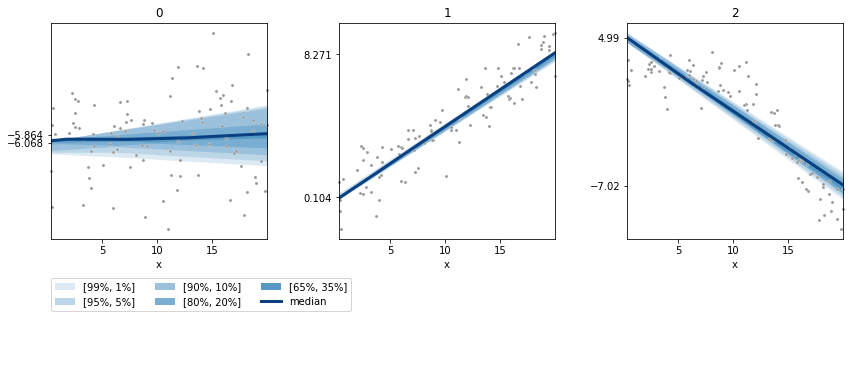

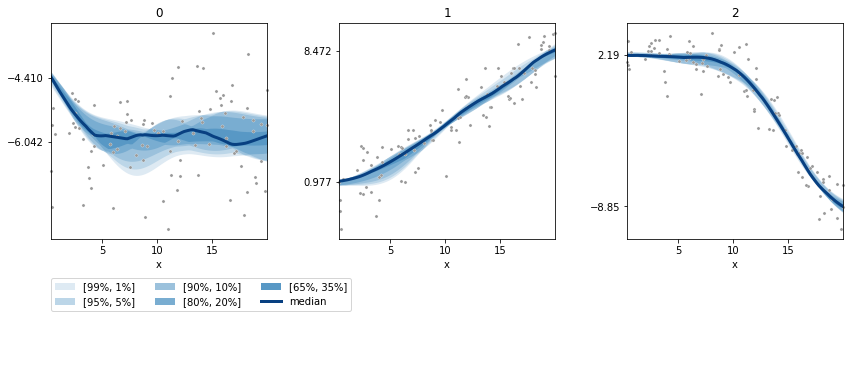

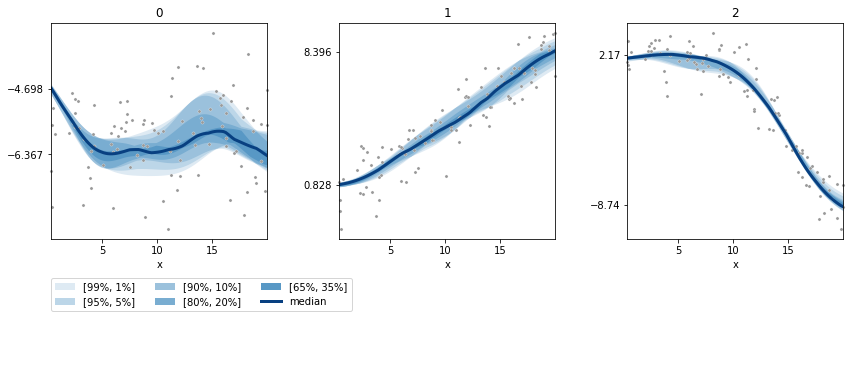

In [71]:
for model_id, model in models.items():
    causal = model["causal"]
    fig = causal.plot_features(show=True)